In [17]:
%run ../robustness_analysis.ipynb

In [2]:
__credits__ = ["Andrea PIERRÉ"]

import math
import warnings
from typing import Optional

import numpy as np

import gym
from gym import error, spaces
from gym.error import DependencyNotInstalled
from gym.utils import EzPickle, colorize, seeding
from types import SimpleNamespace

try:
    import Box2D
    from Box2D.b2 import (
        circleShape,
        contactListener,
        edgeShape,
        fixtureDef,
        polygonShape,
        revoluteJointDef,
    )
except ImportError:
    raise DependencyNotInstalled("box2d is not installed, run `pip install gym[box2d]`")

FPS = 50
SCALE = 30.0  # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER = 13.0
SIDE_ENGINE_POWER = 0.6

INITIAL_RANDOM = 500.0  # Set 1500 to make game harder

LANDER_POLY = [(-14, +17), (-17, 0), (-17, -10), (+17, -10), (+17, 0), (+14, +17)]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14.0
SIDE_ENGINE_AWAY = 12.0

VIEWPORT_W = 600
VIEWPORT_H = 400


class ContactDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env

    def BeginContact(self, contact):
        if (
            self.env.lander == contact.fixtureA.body
            or self.env.lander == contact.fixtureB.body
        ):
            self.env.game_over = True
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = True

    def EndContact(self, contact):
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = False


class LunarLander(gym.Env, EzPickle):
    """
    ### Description
    This environment is a classic rocket trajectory optimization problem.
    According to Pontryagin's maximum principle, it is optimal to fire the
    engine at full throttle or turn it off. This is the reason why this
    environment has discrete actions: engine on or off.

    There are two environment versions: discrete or continuous.
    The landing pad is always at coordinates (0,0). The coordinates are the
    first two numbers in the state vector.
    Landing outside of the landing pad is possible. Fuel is infinite, so an agent
    can learn to fly and then land on its first attempt.

    To see a heuristic landing, run:
    ```
    python gym/envs/box2d/lunar_lander.py
    ```
    <!-- To play yourself, run: -->
    <!-- python examples/agents/keyboard_agent.py LunarLander-v2 -->

    ### Action Space
    There are four discrete actions available: do nothing, fire left
    orientation engine, fire main engine, fire right orientation engine.

    ### Observation Space
    There are 8 states: the coordinates of the lander in `x` & `y`, its linear
    velocities in `x` & `y`, its angle, its angular velocity, and two booleans
    that represent whether each leg is in contact with the ground or not.

    ### Rewards
    Reward for moving from the top of the screen to the landing pad and coming
    to rest is about 100-140 points.
    If the lander moves away from the landing pad, it loses reward.
    If the lander crashes, it receives an additional -100 points. If it comes
    to rest, it receives an additional +100 points. Each leg with ground
    contact is +10 points.
    Firing the main engine is -0.3 points each frame. Firing the side engine
    is -0.03 points each frame. Solved is 200 points.

    ### Starting State
    The lander starts at the top center of the viewport with a random initial
    force applied to its center of mass.

    ### Episode Termination
    The episode finishes if:
    1) the lander crashes (the lander body gets in contact with the moon);
    2) the lander gets outside of the viewport (`x` coordinate is greater than 1);
    3) the lander is not awake. From the [Box2D docs](https://box2d.org/documentation/md__d_1__git_hub_box2d_docs_dynamics.html#autotoc_md61),
        a body which is not awake is a body which doesn't move and doesn't
        collide with any other body:
    > When Box2D determines that a body (or group of bodies) has come to rest,
    > the body enters a sleep state which has very little CPU overhead. If a
    > body is awake and collides with a sleeping body, then the sleeping body
    > wakes up. Bodies will also wake up if a joint or contact attached to
    > them is destroyed.

    ### Arguments
    To use to the _continuous_ environment, you need to specify the
    `continuous=True` argument like below:
    ```python
    import gym
    env = gym.make(
        "LunarLander-v2",
        continuous: bool = False,
        gravity: float = -10.0,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
    )
    ```
    If `continuous=True` is passed, continuous actions (corresponding to the throttle of the engines) will be used and the
    action space will be `Box(-1, +1, (2,), dtype=np.float32)`.
    The first coordinate of an action determines the throttle of the main engine, while the second
    coordinate specifies the throttle of the lateral boosters.
    Given an action `np.array([main, lateral])`, the main engine will be turned off completely if
    `main < 0` and the throttle scales affinely from 50% to 100% for `0 <= main <= 1` (in particular, the
    main engine doesn't work  with less than 50% power).
    Similarly, if `-0.5 < lateral < 0.5`, the lateral boosters will not fire at all. If `lateral < -0.5`, the left
    booster will fire, and if `lateral > 0.5`, the right booster will fire. Again, the throttle scales affinely
    from 50% to 100% between -1 and -0.5 (and 0.5 and 1, respectively).

    `gravity` dictates the gravitational constant, this is bounded to be within 0 and -12.

    If `enable_wind=True` is passed, there will be wind effects applied to the lander.
    The wind is generated using the function `tanh(sin(2 k (t+C)) + sin(pi k (t+C)))`.
    `k` is set to 0.01.
    `C` is sampled randomly between -9999 and 9999.

    `wind_power` dictates the maximum magnitude of linear wind applied to the craft. The recommended value for `wind_power` is between 0.0 and 20.0.
    `turbulence_power` dictates the maximum magnitude of rotational wind applied to the craft. The recommended value for `turbulence_power` is between 0.0 and 2.0.

    ### Version History
    - v2: Count energy spent and in v0.24, added turbulance with wind power and turbulence_power parameters
    - v1: Legs contact with ground added in state vector; contact with ground
        give +10 reward points, and -10 if then lose contact; reward
        renormalized to 200; harder initial random push.
    - v0: Initial version

    <!-- ### References -->

    ### Credits
    Created by Oleg Klimov
    """

    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": FPS}

    def __init__(
        self,
        continuous: bool = False,
        gravity: float = -10.0,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
    ):
        EzPickle.__init__(self)
        self.seed()
        
        self.spec = SimpleNamespace()
        self.spec.id = f"LunarLander-{wind_power:.3f}-{turbulence_power:.3f}"

        assert (
            -12.0 < gravity and gravity < 0.0
        ), f"gravity (current value: {gravity}) must be between -12 and 0"
        self.gravity = gravity

        if 0.0 > wind_power or wind_power > 20.0:
            warnings.warn(
                colorize(
                    f"WARN: wind_power value is recommended to be between 0.0 and 20.0, (current value: {wind_power})",
                    "yellow",
                ),
            )
        self.wind_power = wind_power

        if 0.0 > turbulence_power or turbulence_power > 2.0:
            warnings.warn(
                colorize(
                    f"WARN: turbulence_power value is recommended to be between 0.0 and 2.0, (current value: {turbulence_power})",
                    "yellow",
                ),
            )
        self.turbulence_power = turbulence_power

        self.enable_wind = enable_wind
        self.wind_idx = self.np_random.randint(-9999, 9999)
        self.torque_idx = self.np_random.randint(-9999, 9999)

        self.screen = None
        self.clock = None
        self.isopen = True
        self.world = Box2D.b2World(gravity=(0, gravity))
        self.moon = None
        self.lander = None
        self.particles = []

        self.prev_reward = None

        self.continuous = continuous

        low = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                -1.5,
                -1.5,
                # velocity bounds is 5x rated speed
                -5.0,
                -5.0,
                -math.pi,
                -5.0,
                -0.0,
                -0.0,
            ]
        ).astype(np.float32)
        high = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                1.5,
                1.5,
                # velocity bounds is 5x rated speed
                5.0,
                5.0,
                math.pi,
                5.0,
                1.0,
                1.0,
            ]
        ).astype(np.float32)

        # useful range is -1 .. +1, but spikes can be higher
        self.observation_space = spaces.Box(low, high)

        if self.continuous:
            # Action is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)
        else:
            # Nop, fire left engine, main engine, right engine
            self.action_space = spaces.Discrete(4)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
            
    def _destroy(self):
        if not self.moon:
            return
        self.world.contactListener = None
        self._clean_particles(True)
        self.world.DestroyBody(self.moon)
        self.moon = None
        self.world.DestroyBody(self.lander)
        self.lander = None
        self.world.DestroyBody(self.legs[0])
        self.world.DestroyBody(self.legs[1])
    
    def reset_to(self, center_force, seed=None):
        return self.reset(center_force=center_force, seed=seed)

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        return_info: bool = False,
        options: Optional[dict] = None,
        center_force = None
    ):
        if seed is not None:
            self.seed(seed)
        
        self.wind_idx = self.np_random.randint(-9999, 9999)
        self.torque_idx = self.np_random.randint(-9999, 9999)
        
        self._destroy()
        self.world.contactListener_keepref = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_keepref
        self.game_over = False
        self.prev_shaping = None

        W = VIEWPORT_W / SCALE
        H = VIEWPORT_H / SCALE

        # terrain
        CHUNKS = 11
        height = self.np_random.uniform(0, H / 2, size=(CHUNKS + 1,))
        chunk_x = [W / (CHUNKS - 1) * i for i in range(CHUNKS)]
        self.helipad_x1 = chunk_x[CHUNKS // 2 - 1]
        self.helipad_x2 = chunk_x[CHUNKS // 2 + 1]
        self.helipad_y = H / 4
        height[CHUNKS // 2 - 2] = self.helipad_y
        height[CHUNKS // 2 - 1] = self.helipad_y
        height[CHUNKS // 2 + 0] = self.helipad_y
        height[CHUNKS // 2 + 1] = self.helipad_y
        height[CHUNKS // 2 + 2] = self.helipad_y
        smooth_y = [
            0.33 * (height[i - 1] + height[i + 0] + height[i + 1])
            for i in range(CHUNKS)
        ]

        self.moon = self.world.CreateStaticBody(
            shapes=edgeShape(vertices=[(0, 0), (W, 0)])
        )
        self.sky_polys = []
        for i in range(CHUNKS - 1):
            p1 = (chunk_x[i], smooth_y[i])
            p2 = (chunk_x[i + 1], smooth_y[i + 1])
            self.moon.CreateEdgeFixture(vertices=[p1, p2], density=0, friction=0.1)
            self.sky_polys.append([p1, p2, (p2[0], H), (p1[0], H)])

        self.moon.color1 = (0.0, 0.0, 0.0)
        self.moon.color2 = (0.0, 0.0, 0.0)

        initial_y = VIEWPORT_H / SCALE
        self.lander = self.world.CreateDynamicBody(
            position=(VIEWPORT_W / SCALE / 2, initial_y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=polygonShape(
                    vertices=[(x / SCALE, y / SCALE) for x, y in LANDER_POLY]
                ),
                density=5.0,
                friction=0.1,
                categoryBits=0x0010,
                maskBits=0x001,  # collide only with ground
                restitution=0.0,
            ),  # 0.99 bouncy
        )
        self.lander.color1 = (128, 102, 230)
        self.lander.color2 = (77, 77, 128)
        if center_force is None:
            self.lander.ApplyForceToCenter(
                (
                    self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
                    self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
                ),
                True,
            )
        else:
            self.lander.ApplyForceToCenter(
                center_force,
                True,
            )

        self.legs = []
        for i in [-1, +1]:
            leg = self.world.CreateDynamicBody(
                position=(VIEWPORT_W / SCALE / 2 - i * LEG_AWAY / SCALE, initial_y),
                angle=(i * 0.05),
                fixtures=fixtureDef(
                    shape=polygonShape(box=(LEG_W / SCALE, LEG_H / SCALE)),
                    density=1.0,
                    restitution=0.0,
                    categoryBits=0x0020,
                    maskBits=0x001,
                ),
            )
            leg.ground_contact = False
            leg.color1 = (128, 102, 230)
            leg.color2 = (77, 77, 128)
            rjd = revoluteJointDef(
                bodyA=self.lander,
                bodyB=leg,
                localAnchorA=(0, 0),
                localAnchorB=(i * LEG_AWAY / SCALE, LEG_DOWN / SCALE),
                enableMotor=True,
                enableLimit=True,
                maxMotorTorque=LEG_SPRING_TORQUE,
                motorSpeed=+0.3 * i,  # low enough not to jump back into the sky
            )
            if i == -1:
                rjd.lowerAngle = (
                    +0.9 - 0.5
                )  # The most esoteric numbers here, angled legs have freedom to travel within
                rjd.upperAngle = +0.9
            else:
                rjd.lowerAngle = -0.9
                rjd.upperAngle = -0.9 + 0.5
            leg.joint = self.world.CreateJoint(rjd)
            self.legs.append(leg)

        self.drawlist = [self.lander] + self.legs

        if not return_info:
            return self.step(np.array([0, 0]) if self.continuous else 0)[0]
        else:
            return self.step(np.array([0, 0]) if self.continuous else 0)[0], {}

    def _create_particle(self, mass, x, y, ttl):
        p = self.world.CreateDynamicBody(
            position=(x, y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=circleShape(radius=2 / SCALE, pos=(0, 0)),
                density=mass,
                friction=0.1,
                categoryBits=0x0100,
                maskBits=0x001,  # collide only with ground
                restitution=0.3,
            ),
        )
        p.ttl = ttl
        self.particles.append(p)
        self._clean_particles(False)
        return p

    def _clean_particles(self, all):
        while self.particles and (all or self.particles[0].ttl < 0):
            self.world.DestroyBody(self.particles.pop(0))

    def step(self, action):
        # Update wind
        if self.enable_wind and not (
            self.legs[0].ground_contact or self.legs[1].ground_contact
        ):
            # the function used for wind is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            wind_mag = (
                math.tanh(
                    math.sin(0.02 * self.wind_idx)
                    + (math.sin(math.pi * 0.01 * self.wind_idx))
                )
                * self.wind_power
            )
            self.wind_idx += 1
            self.lander.ApplyForceToCenter(
                (wind_mag, 0.0),
                True,
            )

            # the function used for torque is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            torque_mag = math.tanh(
                math.sin(0.02 * self.torque_idx)
                + (math.sin(math.pi * 0.01 * self.torque_idx))
            ) * (self.turbulence_power)
            self.torque_idx += 1
            self.lander.ApplyTorque(
                (torque_mag),
                True,
            )

        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(
                action
            ), f"{action!r} ({type(action)}) invalid "

        # Engines
        tip = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0])
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (
            not self.continuous and action == 2
        ):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0, 1.0) + 1.0) * 0.5  # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            # 4 is move a bit downwards, +-2 for randomness
            ox = tip[0] * (4 / SCALE + 2 * dispersion[0]) + side[0] * dispersion[1]
            oy = -tip[1] * (4 / SCALE + 2 * dispersion[0]) - side[1] * dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(
                3.5,  # 3.5 is here to make particle speed adequate
                impulse_pos[0],
                impulse_pos[1],
                m_power,
            )  # particles are just a decoration
            p.ApplyLinearImpulse(
                (ox * MAIN_ENGINE_POWER * m_power, oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (
            not self.continuous and action in [1, 3]
        ):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                direction = action - 2
                s_power = 1.0
            ox = tip[0] * dispersion[0] + side[0] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            oy = -tip[1] * dispersion[0] - side[1] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            impulse_pos = (
                self.lander.position[0] + ox - tip[0] * 17 / SCALE,
                self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT / SCALE,
            )
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse(
                (ox * SIDE_ENGINE_POWER * s_power, oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )

        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)

        pos = self.lander.position
        vel = self.lander.linearVelocity
        state = [
            (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2),
            (pos.y - (self.helipad_y + LEG_DOWN / SCALE)) / (VIEWPORT_H / SCALE / 2),
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS,
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS,
            self.lander.angle,
            20.0 * self.lander.angularVelocity / FPS,
            1.0 if self.legs[0].ground_contact else 0.0,
            1.0 if self.legs[1].ground_contact else 0.0,
        ]
        assert len(state) == 8

        reward = 0
        shaping = (
            -100 * np.sqrt(state[0] * state[0] + state[1] * state[1])
            - 100 * np.sqrt(state[2] * state[2] + state[3] * state[3])
            - 100 * abs(state[4])
            + 10 * state[6]
            + 10 * state[7]
        )  # And ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        reward -= (
            m_power * 0.30
        )  # less fuel spent is better, about -30 for heuristic landing
        reward -= s_power * 0.03

        done = False
        if self.game_over or abs(state[0]) >= 1.0:
            done = True
            reward = -100
        if not self.lander.awake:
            done = True
            reward = +100
        return np.array(state, dtype=np.float32), reward, done, {}

    def render(self, mode="human"):
        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[box2d]`"
            )

        if self.screen is None:
            pygame.init()
            pygame.display.init()
            self.screen = pygame.display.set_mode((VIEWPORT_W, VIEWPORT_H))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        self.surf = pygame.Surface(self.screen.get_size())

        pygame.transform.scale(self.surf, (SCALE, SCALE))
        pygame.draw.rect(self.surf, (255, 255, 255), self.surf.get_rect())

        for obj in self.particles:
            obj.ttl -= 0.15
            obj.color1 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )
            obj.color2 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )

        self._clean_particles(False)

        for p in self.sky_polys:
            scaled_poly = []
            for coord in p:
                scaled_poly.append((coord[0] * SCALE, coord[1] * SCALE))
            pygame.draw.polygon(self.surf, (0, 0, 0), scaled_poly)
            gfxdraw.aapolygon(self.surf, scaled_poly, (0, 0, 0))

        for obj in self.particles + self.drawlist:
            for f in obj.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    pygame.draw.circle(
                        self.surf,
                        color=obj.color1,
                        center=trans * f.shape.pos * SCALE,
                        radius=f.shape.radius * SCALE,
                    )
                    pygame.draw.circle(
                        self.surf,
                        color=obj.color2,
                        center=trans * f.shape.pos * SCALE,
                        radius=f.shape.radius * SCALE,
                    )

                else:
                    path = [trans * v * SCALE for v in f.shape.vertices]
                    pygame.draw.polygon(self.surf, color=obj.color1, points=path)
                    gfxdraw.aapolygon(self.surf, path, obj.color1)
                    pygame.draw.aalines(
                        self.surf, color=obj.color2, points=path, closed=True
                    )

                for x in [self.helipad_x1, self.helipad_x2]:
                    x = x * SCALE
                    flagy1 = self.helipad_y * SCALE
                    flagy2 = flagy1 + 50
                    pygame.draw.line(
                        self.surf,
                        color=(255, 255, 255),
                        start_pos=(x, flagy1),
                        end_pos=(x, flagy2),
                        width=1,
                    )
                    pygame.draw.polygon(
                        self.surf,
                        color=(204, 204, 0),
                        points=[
                            (x, flagy2),
                            (x, flagy2 - 10),
                            (x + 25, flagy2 - 5),
                        ],
                    )
                    gfxdraw.aapolygon(
                        self.surf,
                        [(x, flagy2), (x, flagy2 - 10), (x + 25, flagy2 - 5)],
                        (204, 204, 0),
                    )
                
                pygame.draw.line(
                    self.surf,
                    color=(255, 0, 0),
                    start_pos=(VIEWPORT_W / 2 - VIEWPORT_W * 0.1, flagy1),
                    end_pos=(VIEWPORT_W / 2 - VIEWPORT_W * 0.1 - VIEWPORT_H * 0.6, VIEWPORT_H),
                    width=3
                )
                pygame.draw.line(
                    self.surf,
                    color=(255, 0, 0),
                    start_pos=(VIEWPORT_W / 2 + VIEWPORT_W * 0.1, flagy1),
                    end_pos=(VIEWPORT_W / 2 + VIEWPORT_W * 0.1 + VIEWPORT_H * 0.6, VIEWPORT_H),
                    width=3
                )

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))

        if mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        if mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.surf)), axes=(1, 0, 2)
            )
        else:
            return self.isopen

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


def heuristic(env, s):
    """
    The heuristic for
    1. Testing
    2. Demonstration rollout.

    Args:
        env: The environment
        s (list): The state. Attributes:
            s[0] is the horizontal coordinate
            s[1] is the vertical coordinate
            s[2] is the horizontal speed
            s[3] is the vertical speed
            s[4] is the angle
            s[5] is the angular speed
            s[6] 1 if first leg has contact, else 0
            s[7] 1 if second leg has contact, else 0

    Returns:
         a: The heuristic to be fed into the step function defined above to determine the next step and reward.
    """

    angle_targ = s[0] * 0.5 + s[2] * 1.0  # angle should point towards center
    if angle_targ > 0.4:
        angle_targ = 0.4  # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4:
        angle_targ = -0.4
    hover_targ = 0.55 * np.abs(
        s[0]
    )  # target y should be proportional to horizontal offset

    angle_todo = (angle_targ - s[4]) * 0.5 - (s[5]) * 1.0
    hover_todo = (hover_targ - s[1]) * 0.5 - (s[3]) * 0.5

    if s[6] or s[7]:  # legs have contact
        angle_todo = 0
        hover_todo = (
            -(s[3]) * 0.5
        )  # override to reduce fall speed, that's all we need after contact

    if env.continuous:
        a = np.array([hover_todo * 20 - 1, -angle_todo * 20])
        a = np.clip(a, -1, +1)
    else:
        a = 0
        if hover_todo > np.abs(angle_todo) and hover_todo > 0.05:
            a = 2
        elif angle_todo < -0.05:
            a = 3
        elif angle_todo > +0.05:
            a = 1
    return a


def demo_heuristic_lander(env, seed=None, render=False):

    total_reward = 0
    steps = 0
    s = env.reset(seed=seed)
    while True:
        a = heuristic(env, s)
        s, r, done, info = env.step(a)
        total_reward += r

        if render:
            still_open = env.render()
            if still_open is False:
                break

        if steps % 20 == 0 or done:
            print("observations:", " ".join([f"{x:+0.2f}" for x in s]))
            print(f"step {steps} total_reward {total_reward:+0.2f}")
        steps += 1
        if done:
            break
    if render:
        env.close()
    return total_reward

In [3]:
# define variables and their bounds
wind_power = [0.0, 20.0]
turbulence_power = [0.0, 2.0]

# define the range of the deviation parameters
dev_bounds = np.asarray([wind_power, turbulence_power])

# define the range of initial force apply to the lander
x0_bounds = np.repeat([[-INITIAL_RANDOM, INITIAL_RANDOM]], 2, axis=0)

# define the deviation parameter value for the original environment (no deviation)
delta_0 = np.asarray([5.0, 0.5])

In [4]:
def env_builder(delta):
    return LunarLander(enable_wind=True, continuous=True, wind_power=delta[0], turbulence_power=delta[1]), x0_bounds

In [5]:
from scipy import linalg

def lqr(s):
    # gravity = 9.8/FPS/FPS/SCALE
    gravity = 9.8 / FPS / FPS # gravity changes depending on SCALE
    m_main_inv = gravity / 0.56    # determined by test
    m_side_inv = gravity * 0.365    # determined by test
    a_sina_i_inv= 0.198 / 100 # determined by test # not depending on SCALE
    cos_alpha = 0.72

    # target point set
    x_target = 0
    y_target = 0   # the landing point is 0
    Vx_target = 0
    Vy_target = 0
    theta_target = 0
    omega_target = 0

    """
    Design of the reference trajectory
    """
    y_target = s[1] * (VIEWPORT_H / SCALE / 2) / 1.6 # 1.6 succeeds all the times

    """
    Design of a state space representation
    """
    X = np.array([
        [s[0] * (VIEWPORT_W / SCALE / 2) - x_target],
        [s[1] * (VIEWPORT_H / SCALE / 2) - y_target],
        [s[2] / (VIEWPORT_W / SCALE / 2) - Vx_target],
        [s[3] / (VIEWPORT_H / SCALE / 2) - Vy_target],
        [s[4] - theta_target],
        [s[5] / 20.0 - omega_target]
    ])

    A = np.array([
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, -1 * gravity, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0]
    ])

    B = np.array([
        [0, 0],
        [0, 0],
        [0, m_side_inv * cos_alpha * cos_alpha],
        [1 * m_main_inv, 0],
        [0, 0],
        [0, -1 * a_sina_i_inv]
    ])
    # the second term of the 4th row of B was igonred for simplification assuming that Fside is smaller than Fmain and negligible while Fmain is used

    sigma = np.array([
        [0],
        [0],
        [0],
        [-1 * gravity],
        [0],
        [0]
    ])

    # gravity compensation
    BTB = np.dot(B.T, B)
    u_sigma = -1 * np.linalg.inv(BTB).dot(B.T).dot(sigma)

    """
    Design of LQR
    Solve Riccati equation to find a optimal control input
    """
    R = np.array([
        [1, 0],
        [0, 1]
    ])

    Q = np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 100, 0],
        [0, 0, 0, 0, 0, 100]
    ])

    # Solving Riccati equation
    P = linalg.solve_continuous_are(A, B, Q, R)
    # print("P {}\n".format(P))

    # u = -KX
    # K = R-1*Rt*P
    K = np.linalg.inv(R).dot(B.T).dot(P)
    # print("K {}\n".format(K))
    thrust = -1 * np.dot(K, X) + u_sigma
    # thrust = -1*np.dot(K, X)

    """
    Free fall from the final short distance
    """
    if s[1] < 0.3 / SCALE:
        thrust[0] = 0
        thrust[1] = 0

    # conversion to compensate main thruster's tricky thrusting
    thrust[0] = thrust[0] / 0.5 - 1.0

    a = np.array([thrust[0], thrust[1]])
    a = np.clip(a, -1, +1)  #  if the value is less than 0.5, it's ignored
    return a.flatten()

In [6]:
agent = {
    # define the action generation function of the given agent
    'next_action': lambda obs: lqr(obs),

    # some agents (like PID) needs to be reset for each run
    'model_reset': None
}

In [7]:
obs_space = env_builder(delta_0)[0].observation_space
angle_range = np.asarray([obs_space.low[4], obs_space.high[4]])
x_range = np.asarray([obs_space.low[0], obs_space.high[0]])
y_range = np.asarray([obs_space.low[1], obs_space.high[1]])


def stl_prop():    
    # G ( |angle| < 45 && |x| < 0.6|y| + 0.1 )
    angle = stl.Predicate('angle')
    delta_x = stl.Predicate('delta_x')
    
    angle_threshold = normalize(45 * 2 * np.pi / 360, angle_range)
    
    return stl.Always( (angle < angle_threshold) & (delta_x < 0.1) )
    

def signal_builder(records, time_index):    
    return {
        'angle': stl.Signal(
            normalize(np.abs(records[:, 4]), angle_range),
            time_index
        ),
        'delta_x': stl.Signal(
            normalize(np.abs(records[:, 0]), x_range) - normalize(np.abs(0.6 * records[:, 1]), y_range),
            time_index
        )
    }
    

def episode_eval(obs_record, reward_record):
    return compute_stl_rob(stl_prop(), signal_builder, obs_record)

In [8]:
# l-2 norm distance
def dist(delta, delta_0):
    delta = normalize(delta, dev_bounds)
    delta_0 = normalize(delta_0, dev_bounds)
    return np.sqrt(np.sum((delta - delta_0) ** 2))

In [9]:
if not os.path.exists('gifs'):
    os.mkdir('gifs')
if not os.path.exists('data'):
    os.mkdir('data')

In [18]:
analysis = RobustnessAnalysis(env_builder, agent, episode_eval, delta_0, dev_bounds, dist)
analysis.options['steps_of_each_x0'] = 300
analysis.options['falsification_timeout'] = 1
analysis.options['falsification_num_trials'] = 2
analysis.options['deviation_timeout'] = 40
analysis.options

{'epsilon': 0.01,
 'deviation_num_trials': 3,
 'deviation_sigma': 0.2,
 'deviation_timeout': 40,
 'falsification_sigma': 0.2,
 'falsification_timeout': 1,
 'falsification_num_trials': 2,
 'falsification_episodes': 100,
 'episodes_of_each_x0': 1,
 'steps_of_each_x0': 300}

In [20]:
delta, delta_dist = analysis.min_unsafe_deviation()


================ Min unsafe deviation trial 1 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=278996, Sun Oct 30 19:12:07 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 1.197626840421144e-01 1.0e+00 1.67e-01  1e-01  2e-01 12:32.6
    2     12 -7.682074784233717e-03 1.2e+00 1.24e-01  9e-02  1e-01 25:01.2
    3     18 4.161681593602239e-02 1.1e+00 9.69e-02  6e-02  7e-02 37:30.8
    4     24 2.150085748575816e-02 1.3e+00 7.66e-02  4e-02  5e-02 50:08.2
termination on timeout=2400 (Sun Oct 30 20:04:20 2022)
final/bestever f-value = 3.565663e-02 -7.682075e-03
incumbent solution: [0.261752256070356, 0.26279412466269836]
std deviation: [0.042852296216937015, 0.052774824808295574]
CMAEvolutionStrategyResult(xbest=array([0.29213074, 0.24182888]), fbest=-0.007682074784233717, evals_best=10, evaluations=25, iterations=4, xfavorite=array([0.26175226, 0.26279412]), stds=array([0.0428523 , 0.05277482]), stop={'timeout': 2400})
{'x':

In [21]:
print(delta, delta_dist)

[5.84261486 0.48365775] 0.04291581028398164


STL robustness value: -0.11906501054763793
Initial state: [-499.74020601  309.40424934]


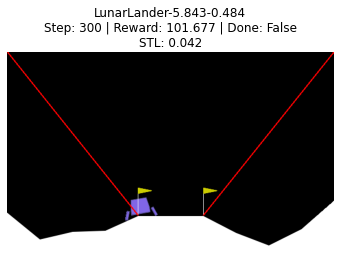

In [22]:
analysis.visualize_deviation(delta, "gifs/min_counterexample.gif")

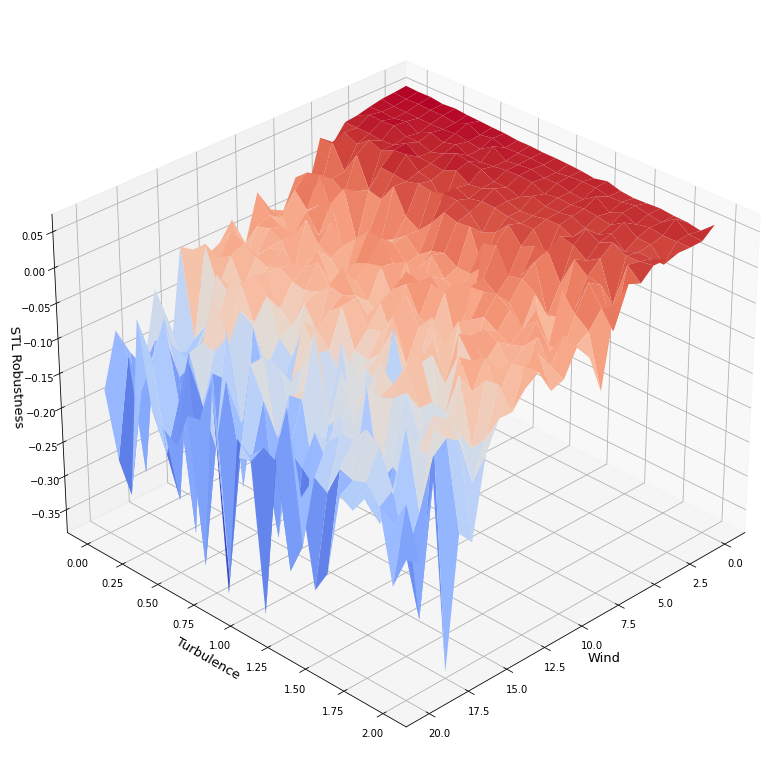

In [11]:
ax, winds, turbulences, grid_data = analysis.grid_plot(wind_power, turbulence_power, 25, 25,
                                                       x_name="Wind", y_name="Turbulence",
                                                       z_name='STL Robustness')
ax.view_init(30, 45)
plt.savefig('gifs/robustness-landscape.png')
plt.show()

In [12]:
analysis.robustness_boundary()


================ Min unsafe deviation trial 1 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=96451, Sat Oct 29 00:24:50 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 7.369771855315037e-02 1.0e+00 1.74e-01  2e-01  2e-01 12:39.6
    2     12 8.703200438954420e-02 1.1e+00 1.44e-01  1e-01  1e-01 25:11.0
    3     18 1.389745219469014e-01 1.2e+00 1.30e-01  8e-02  1e-01 37:43.2
    4     24 1.220564712057644e-01 1.3e+00 1.04e-01  6e-02  8e-02 50:17.0
termination on timeout=2400 (Sat Oct 29 01:17:15 2022)
final/bestever f-value = 8.516644e-02 7.369772e-02
incumbent solution: [0.38188980550251284, 0.3386693154225284]
std deviation: [0.05581643057709584, 0.08197088416464682]
CMAEvolutionStrategyResult(xbest=array([0.31478853, 0.21487452]), fbest=0.07369771855315037, evals_best=5, evaluations=25, iterations=4, xfavorite=array([0.38188981, 0.33866932]), stds=array([0.05581643, 0.08197088]), stop={'timeout': 2400})
{'x': array(

    4     24 3.898998139470387e-03 1.3e+00 1.20e-01  9e-02  9e-02 50:09.1
termination on timeout=2400 (Sat Oct 29 07:23:48 2022)
final/bestever f-value = 2.364013e-03 2.364013e-03
incumbent solution: [0.22153036157221342, 0.27798225993087156]
std deviation: [0.09462113518828058, 0.09127236122526965]
CMAEvolutionStrategyResult(xbest=array([0.22153036, 0.27798226]), fbest=0.0023640127839985436, evals_best=25, evaluations=25, iterations=4, xfavorite=array([0.22153036, 0.27798226]), stds=array([0.09462114, 0.09127236]), stop={'timeout': 2400})

================ Min unsafe deviation trial 3 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=149670, Sat Oct 29 07:23:48 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 1.197809700421923e-02 1.0e+00 1.68e-01  1e-01  2e-01 12:32.6
    2     12 2.306270934626944e-03 1.1e+00 1.29e-01  9e-02  1e-01 25:11.3
    3     18 3.289956995673250e-04 1.2e+00 1.31e-01  1e-01  1e-01 37:47.3
    4  

0.063658601375221

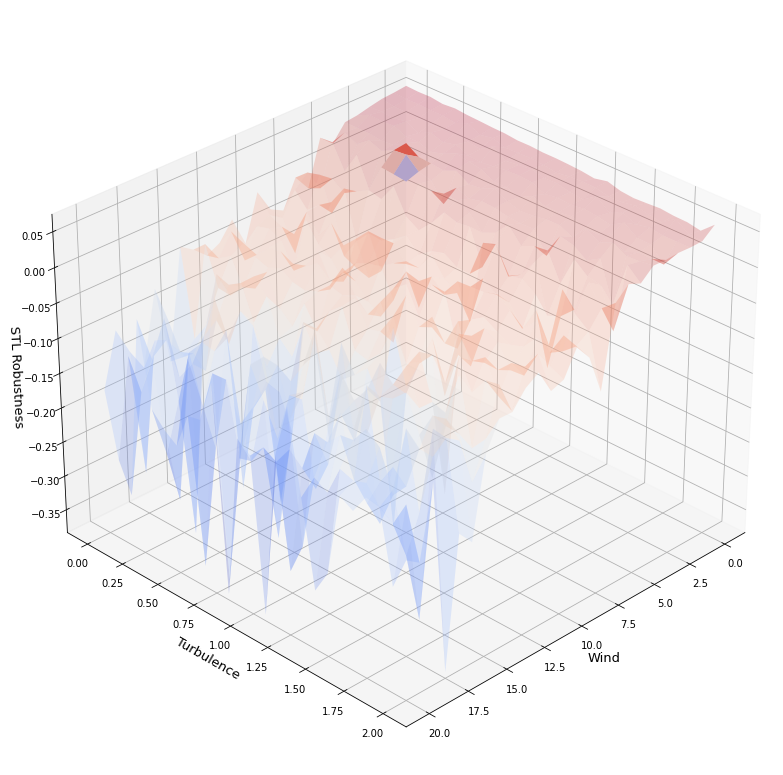

In [19]:
ax, winds, turbulences, grid_data = analysis.grid_plot(wind_power, turbulence_power, 25, 25,
                                                       x_name="Wind", y_name="Turbulence",
                                                       z_name='STL Robustness', boundary=0.063659)
ax.view_init(30, 45)
plt.savefig('gifs/robustness-landscape-boundary.png')
plt.show()

In [13]:
def episode_eval_reward(obs_record, reward_record):
    return reward_record.sum()

In [14]:
analysis_reward = RobustnessAnalysis(env_builder, agent, episode_eval_reward, delta_0, dev_bounds, dist)
analysis_reward.options['steps_of_each_x0'] = 300
analysis_reward.options['falsification_timeout'] = 1
analysis_reward.options['falsification_num_trials'] = 3
analysis_reward.options['deviation_timeout'] = 20
analysis_reward.options

{'epsilon': 0.01,
 'deviation_num_trials': 3,
 'deviation_sigma': 0.2,
 'deviation_timeout': 20,
 'falsification_sigma': 0.2,
 'falsification_timeout': 1,
 'falsification_num_trials': 3,
 'falsification_episodes': 100,
 'episodes_of_each_x0': 1,
 'steps_of_each_x0': 300}

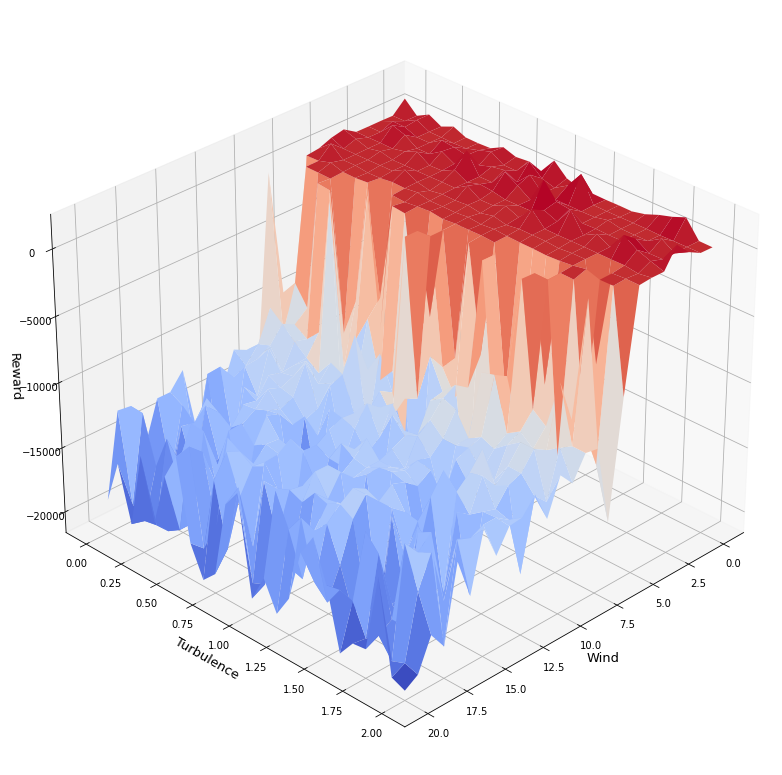

In [15]:
ax, winds, turbulences, grid_data = analysis_reward.grid_plot(wind_power, turbulence_power, 25, 25,
                                                              out_dir='data_reward',
                                                              x_name="Wind", y_name="Turbulence",
                                                              z_name='Reward')
ax.view_init(30, 45)
plt.savefig('gifs/robustness-landscape-reward.png')
plt.show()